In [36]:
#PACKAGES PYTHON

import matplotlib.pyplot as plt
import folium
import pandas as pd
from folium import plugins
import pandas as pd
import json
from folium.plugins import TimestampedGeoJson
from geopy.distance import geodesic
import plotly.express as px
import geopandas as gpd
from shapely.geometry import Point
import numpy as np

import pandas as pd
import numpy as np
from geopy.distance import geodesic

In [37]:
import pandas as pd

# Chargement direct du fichier CSV depuis un chemin local
df = pd.read_csv(r'C:\Users\fgrol\Documents\stages\drones_1million.csv', sep=';')

# Vérification rapide
print(df.shape)



(625500, 7)


Extraction de vitesse, hauteur et altitude

In [38]:


def clean_json_str(s):
    if s.startswith('{drone":'):
        s = '{"' + s[1:]
    if s.endswith('}}"'):
        s = s[:-1]
    return s

def extract_values(s):
    try:
        s_clean = clean_json_str(s)
        d = json.loads(s_clean)
        drone = d.get('drone', {})
        altitude = drone.get('altitude', None)
        hauteur = drone.get('hauteur', None)
        vitesse = drone.get('vitesse', None)
        return altitude, hauteur, vitesse
    except Exception as e:
        print(f"Erreur extraction valeurs : {e}")
        return None, None, None

# Appliquer sur toute la colonne properties
df[['altitude', 'hauteur', 'vitesse']] = df['properties'].apply(
    lambda s: pd.Series(extract_values(s))
)



On aurait pu calculer une autre hauteur du drone

Supprimer la colonne 'properties' du DataFrame original

In [39]:
# Supprimer la colonne 'properties' du DataFrame original
df_initial_sans_properties = df

# Faire la concaténation côte à côte
df_drones = pd.concat([df_initial_sans_properties], axis=1)



Création d'un nouveau csv.

In [40]:


colonnes_voulues = [
    'drone_id',
    'constructeur',
    'modele',
    'updated',  # temps
    'y',
    'x',
    'altitude',
    'hauteur',
    'vitesse',
    'properties'
]

df_kepler_ready = df_drones[colonnes_voulues].copy()

df_kepler_ready.to_csv('drones_kepler.csv', index=False)



MODELISATION DANS KEPLER.GL
pas forcément très pertinente cependant.

TRAVAIL SUR LE FORMAT DES DATES

In [41]:
df['updated'] = pd.to_datetime(df['updated'], utc=True, errors='coerce')
print(df['updated'].dtypes)  # Doit afficher le type de date




datetime64[ns, UTC]


On fonctionne donc en UTC

Les valeurs des vitesses "null" sont changées en valeur 0.

In [42]:
import matplotlib.pyplot as plt

# Assure-toi que 'updated' est datetime (avec fuseau horaire ou en UTC)
df['updated'] = pd.to_datetime(df['updated'], utc=True, errors='coerce')

# Nettoyer la colonne 'vitesse'
df['vitesse'] = pd.to_numeric(df['vitesse'], errors='coerce').fillna(0)
# Trier les données pour plus de clarté
df = df.sort_values(['drone_id', 'updated'])

# Liste des drones uniques
drone_ids = df['drone_id'].unique()






In [43]:
# Lire le fichier CSV
df_clean = pd.read_csv('drones_kepler.csv')
# Vérification rapide
print(df_clean.shape)

(625500, 10)


vitesse null remplacée par vitesse_calculee

In [44]:
# S'assurer que 'updated' est bien en datetime
df_clean['updated'] = pd.to_datetime(df_clean['updated'])

# Trier les données par drone et timestamp
df_clean = df_clean.sort_values(by=['drone_id', 'updated']).reset_index(drop=True)

# Initialiser la colonne des vitesses calculées
df_clean['vitesse_calculee'] = 0.0

# Grouper par drone_id pour calculer la vitesse entre deux points consécutifs
for drone_id, group in df_clean.groupby('drone_id'):
    idxs = group.index
    for i in range(1, len(group)):
        idx_prev = idxs[i - 1]
        idx_curr = idxs[i]

        # Extraire les coordonnées (lat, lon)
        coord_prev = (df_clean.loc[idx_prev, 'y'], df_clean.loc[idx_prev, 'x'])
        coord_curr = (df_clean.loc[idx_curr, 'y'], df_clean.loc[idx_curr, 'x'])

        # Calcul de la distance (mètres)
        distance = geodesic(coord_prev, coord_curr).meters

        # Calcul du temps (secondes)
        t1 = df_clean.loc[idx_prev, 'updated']
        t2 = df_clean.loc[idx_curr, 'updated']
        delta_t = (t2 - t1).total_seconds()

        # Calcul de la vitesse (m/s)
        vitesse = distance / delta_t if delta_t > 0 else 0.0

        df_clean.loc[idx_curr, 'vitesse_calculee'] = vitesse

# Nettoyer la colonne 'vitesse' (s'assurer qu'elle est numérique)
df_clean['vitesse'] = pd.to_numeric(df_clean['vitesse'], errors='coerce')

# Remplacer les valeurs manquantes (NaN) dans 'vitesse' par 'vitesse_calculee'
df_clean['vitesse'] = df_clean['vitesse'].fillna(df_clean['vitesse_calculee'])


C:\Users\fgrol\AppData\Local\Temp\ipykernel_7648\3456638988.py:2: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_clean['updated'] = pd.to_datetime(df_clean['updated'])


In [45]:
print("Nombre de valeurs manquantes dans 'vitesse' :", df_clean['vitesse'].isna().sum())


Nombre de valeurs manquantes dans 'vitesse' : 0


Exemple des trajectoires d'un drone

Ajout des colonnes Trajectoire, distance, vitesse ascensionnelle, temps

In [46]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic

# 1. Convertir 'updated' en datetime avec UTC
df_clean['updated'] = pd.to_datetime(df_clean['updated'], utc=True)

# 2. Trier par drone_id et timestamp
df_clean = df_clean.sort_values(by=['drone_id', 'updated']).reset_index(drop=True)

# 3. Calcul du temps écoulé (delta_t) en secondes
df_clean['delta_t'] = df_clean.groupby('drone_id')['updated'].diff().dt.total_seconds()

# 4. Calcul de la vitesse verticale vz (altitude / temps)
df_clean['vz'] = df_clean.groupby('drone_id')['hauteur'].diff() / df_clean['delta_t']

# 5. Calcul de la distance entre points GPS successifs (avec x = lon, y = lat)
def compute_distance(row):
    i = row.name
    if i == 0 or df_clean.loc[i, 'drone_id'] != df_clean.loc[i - 1, 'drone_id']:
        return 0
    coord1 = (df_clean.loc[i - 1, 'y'], df_clean.loc[i - 1, 'x'])  # (lat, lon)
    coord2 = (df_clean.loc[i, 'y'], df_clean.loc[i, 'x'])          # (lat, lon)
    return geodesic(coord1, coord2).m

df_clean['distance'] = df_clean.apply(compute_distance, axis=1)

# 6. Détection de nouvelle trajectoire si delta_t > 5 minutes ou changement de drone
df_clean['new_traj'] = (
    (df_clean['delta_t'] > 300) |
    (df_clean['drone_id'] != df_clean['drone_id'].shift())
).astype(int)

# 7. Attribution d’un ID de trajectoire unique
df_clean['traj_id'] = df_clean.groupby('drone_id')['new_traj'].cumsum()

# 8. Calcul du temps total et distance totale pour chaque trajectoire
traj_stats = df_clean.groupby(['drone_id', 'traj_id']).agg(
    temps_total=('delta_t', 'sum'),
    distance_totale=('distance', 'sum')
).reset_index()

# Nettoyer les colonnes potentielles en doublon avant merge
for col in ['temps_total', 'distance_totale', 'temps_total_x', 'temps_total_y', 'distance_totale_x', 'distance_totale_y']:
    if col in df_clean.columns:
        df_clean.drop(columns=[col], inplace=True)

# 9. Fusion des statistiques dans le dataframe principal
df_clean = df_clean.merge(traj_stats, on=['drone_id', 'traj_id'], how='left')

# 10. Nettoyage de la colonne temporaire
df_clean.drop(columns=['new_traj'], inplace=True)



Plot des vitesses rapportées au temps

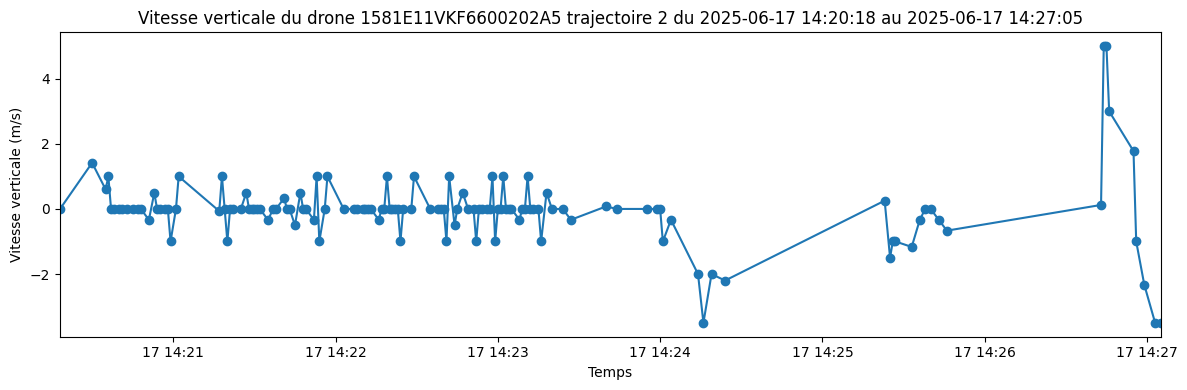

In [47]:
import matplotlib.pyplot as plt

# Assure que 'vz' est numérique
df_clean['vz'] = pd.to_numeric(df_clean['vz'], errors='coerce').fillna(0)

# Tri par drone, trajectoire et temps
df_clean = df_clean.sort_values(['drone_id', 'traj_id', 'updated'])

# Récupère tous les groupes uniques
group_keys = list(df_clean.groupby(['drone_id', 'traj_id']).groups.keys())

# Vérifie qu'il y a au moins 9 groupes
if len(group_keys) >= 9:
    # On récupère la 9ᵉ (index 8 car indexation commence à 0)
    selected_key = group_keys[8]
    drone, traj = selected_key

    df_sub = df_clean[(df_clean['drone_id'] == drone) & (df_clean['traj_id'] == traj)]

    if not df_sub.empty:
        fig, ax = plt.subplots(figsize=(12, 4))

        start = df_sub['updated'].min().strftime('%Y-%m-%d %H:%M:%S')
        end = df_sub['updated'].max().strftime('%Y-%m-%d %H:%M:%S')

        ax.plot(df_sub['updated'], df_sub['vz'], marker='o', linestyle='-')
        ax.set_xlim(df_sub['updated'].min(), df_sub['updated'].max())

        ax.set_title(f"Vitesse verticale du drone {drone} trajectoire {traj} du {start} au {end}")
        ax.set_xlabel("Temps")
        ax.set_ylabel("Vitesse verticale (m/s)")

        plt.tight_layout()
        plt.show()
    else:
        print("Le groupe sélectionné est vide.")
else:
    print("Moins de 9 trajectoires disponibles.")


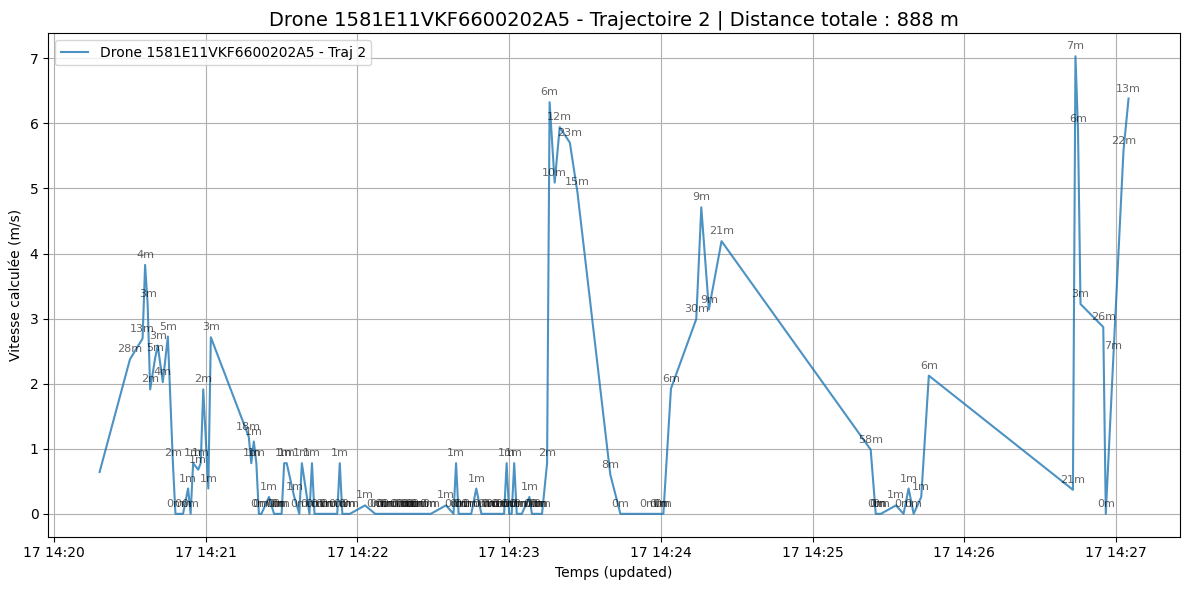

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assurer que 'updated' est bien au format datetime
df_clean['updated'] = pd.to_datetime(df_clean['updated'])

# Obtenir les 10 premières combinaisons uniques
top_10_traj = df_clean[['drone_id', 'traj_id']].drop_duplicates().head(10)

# Vérifier qu'on a au moins 9 trajectoires
if len(top_10_traj) >= 9:
    # Récupérer la 9ᵉ trajectoire (index 8)
    row = top_10_traj.iloc[8]
    drone_id = row['drone_id']
    traj_id = row['traj_id']

    # Filtrer les données de cette trajectoire
    group = df_clean[(df_clean['drone_id'] == drone_id) & (df_clean['traj_id'] == traj_id)]
    group = group.sort_values('updated')

    # Calcul de la distance totale
    distance_totale = group['distance'].sum()

    # Tracer la figure
    plt.figure(figsize=(12, 6))
    plt.plot(group['updated'], group['vitesse_calculee'],
             label=f'Drone {drone_id} - Traj {traj_id}',
             color='tab:blue', alpha=0.8)

    # Annoter chaque point avec la distance
    for i in range(1, len(group)):
        x = group.iloc[i]['updated']
        y = group.iloc[i]['vitesse_calculee']
        dist = group.iloc[i]['distance']
        plt.annotate(f"{dist:.0f}m", (x, y),
                     textcoords="offset points", xytext=(0, 5),
                     ha='center', fontsize=8, alpha=0.6)

    # Ajouter titre et axes
    plt.title(
        f"Drone {drone_id} - Trajectoire {traj_id} | Distance totale : {distance_totale:.0f} m",
        fontsize=14
    )
    plt.xlabel("Temps (updated)")
    plt.ylabel("Vitesse calculée (m/s)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Moins de 9 trajectoires disponibles.")


Ajout de la distance entre télécommande et point le plus loin (portée)

In [49]:

# Fonction pour calculer la distance max au point (x0, y0)
def compute_max_distance_to_start(group):
    x0, y0 = group.iloc[0][['x', 'y']]  # point de la télécommande
    distances = np.sqrt((group['x'] - x0)**2 + (group['y'] - y0)**2)
    max_distance = distances.max()
    group['distance_max_telecommande'] = max_distance
    return group

# Appliquer la fonction par trajectoire
df_clean = df_clean.groupby(['drone_id', 'traj_id'], group_keys=False).apply(compute_max_distance_to_start)





C:\Users\fgrol\AppData\Local\Temp\ipykernel_7648\3502637546.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_clean = df_clean.groupby(['drone_id', 'traj_id'], group_keys=False).apply(compute_max_distance_to_start)


Extraction de Latitude_départ et longitude_départ

In [50]:


def clean_json_str(s):
    if s.startswith('{drone":'):
        s = '{"' + s[1:]
    if s.endswith('}}"'):
        s = s[:-1]
    return s

def extract_lat_lon(s):
    try:
        s_clean = clean_json_str(s)
        d = json.loads(s_clean)
        drone = d.get('drone', {})
        latitude_depart = drone.get('latitude_depart', None)
        longitude_depart = drone.get('longitude_depart', None)
        return latitude_depart, longitude_depart
    except Exception as e:
        print(f"Erreur extraction coordonnées : {e}")
        return None, None

# Application sur df_clean
df_clean[['latitude_depart', 'longitude_depart']] = df_clean['properties'].apply(
    lambda s: pd.Series(extract_lat_lon(s))
)


On a certaines valeurs qui sont aberrantes et liées à un mauvais renseignement de la donnée par le drone.
On change les latitudes/longitudes aberrantes par 0.

In [51]:
import numpy as np

# Définir les bornes valides de la France métropolitaine
lat_min, lat_max = 41.0, 51.5
lon_min, lon_max = -5.5, 9.5

# Masques de validité
lat_valid = df_clean['latitude_depart'].between(lat_min, lat_max)
lon_valid = df_clean['longitude_depart'].between(lon_min, lon_max)

# Remplacer par NaN si hors des bornes
df_clean.loc[~lat_valid, 'latitude_depart'] = np.nan
df_clean.loc[~lon_valid, 'longitude_depart'] = np.nan


Ajout de la colonne Distance_depart (portée)

In [52]:
import numpy as np

def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # rayon terrestre en mètres
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)

    a = np.sin(dphi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return R * c  # distance en mètres

# Distance par rapport au point de départ GPS
df_clean['distance_from_depart'] = df_clean.apply(
    lambda row: haversine(row['latitude_depart'], row['longitude_depart'], row['y'], row['x']), axis=1
)

# Distance maximale par groupe
df_clean['distance_depart'] = df_clean.groupby(['drone_id', 'traj_id'])['distance_from_depart'].transform('max')
# Remplacer la colonne par une version formatée en string
df_clean['distance_depart'] = df_clean['distance_depart'].apply(lambda x: f"{x:.2f}")

df_clean.drop(columns=['distance_from_depart'], inplace=True)



Standardisation du nom des modèles

In [ ]:
import pandas as pd
import unidecode
from rapidfuzz import process

# === 1. Liste officielle des modèles ===
modeles_ref = [
    "Mini 4K", "Mini 3 Pro", "Mini 3", "Mini 2 SE", "Mini SE", "Air 3S", "Air 3", "Air 2S",
    "Mavic 4 Pro", "Mavic 3 Pro", "Mavic 3 Classic", "Mavic 3", "Mavic 2", "Mavic Pro",
    "Mavic Pro Platinum", "Avata", "FPV (original)", "Inspire 3", "Inspire 2",
    "Matrice 300 RTK", "Matrice 350 RTK", "Matrice 30", "Matrice 30T", "Matrice 400",
    "Matrice 4E", "Matrice 4T", "Mavic 3T", "Mavic 3E", "Mavic 3M",
    "Mavic 2 Enterprise Dual", "Mavic 2 Enterprise Advanced", "Agras T50", "Agras T25",
    "T20", "T25P", "T30", "T60", "T100", "MG-1", "Phantom 4 Pro", "Phantom 4 Advanced",
    "Spreading Wings S1000", "Evo Lite+", "Evo Nano+", "Typhoon H", "Typhoon H Plus",
    "Breeze", "Ghost Drone 2.0", "Atom 2", "Anafi", "Anafi USA", "Mavic 2 Zoom",
    "Phantom 4 RTK", "Extra 330S", "Mavic 2 Pro"
]

# === 2. Fonction de nettoyage des chaînes ===
def normalize(s):
    if pd.isna(s):
        return ""
    s = str(s)
    s = unidecode.unidecode(s).lower()
    s = s.replace("-", " ").replace("_", " ").strip()
    return s

# === 3. Normaliser la liste de référence ===
normalized_ref = {normalize(m): m for m in modeles_ref}
normalized_ref_list = list(normalized_ref.keys())

# === 4. Fonction de correspondance floue robuste ===
def match_model(s, threshold=85):
    s_norm = normalize(s)
    result = process.extractOne(s_norm, normalized_ref_list, score_cutoff=threshold)
    if result:
        match, score, _ = result
        return normalized_ref[match]
    return None

# === 5. Optimisation : matching sur valeurs uniques ===
valeurs_uniques = df_clean["modele"].dropna().unique()
correspondance = {val: match_model(val) for val in valeurs_uniques}

# === 6. Remplacement dans le DataFrame ===
df_clean["modele_standardise"] = df_clean["modele"].map(correspondance)

# === 7. (Optionnel) Export des modèles non reconnus ===
non_reconnus = {k: v for k, v in correspondance.items() if v is None}
pd.Series(non_reconnus).to_csv("modeles_non_reconnus.csv")

# === 8. (Optionnel) Affichage pour vérification ===
print(df_clean[["modele", "modele_standardise"]])

df_clean.to_csv("csv_test.csv", index=False)
print("✅ Le fichier 'csv_test.csv' a été exporté avec succès.")



NameError: name 'df_clean' is not defined

In [54]:
modeles_uniques = df_clean["modele_standardise"].dropna().unique()
modeles_uniques.sort()
for i, modele in enumerate(modeles_uniques):
    print(f"{i+1}: {modele}")




1: Air 2S
2: Air 3
3: Air 3S
4: Avata
5: Extra 330S
6: Inspire 3
7: Matrice 300 RTK
8: Matrice 30T
9: Matrice 350 RTK
10: Matrice 4E
11: Matrice 4T
12: Mavic 2
13: Mavic 2 Enterprise Advanced
14: Mavic 2 Enterprise Dual
15: Mavic 2 Zoom
16: Mavic 3
17: Mavic 3 Classic
18: Mavic 3 Pro
19: Mavic 3E
20: Mavic 3M
21: Mavic 3T
22: Mavic 4 Pro
23: Mavic Pro
24: Mini 2 SE
25: Mini 3 Pro
26: Mini 4K
27: Mini SE
28: Phantom 4 Pro
29: Phantom 4 RTK


                             precision    recall  f1-score   support

                     Air 2S       0.97      0.99      0.98      1538
                      Air 3       0.90      0.94      0.92      1452
                     Air 3S       0.94      0.99      0.96       831
                      Avata       0.97      0.97      0.97       686
                  Inspire 3       0.99      0.99      0.99     15322
            Matrice 300 RTK       0.99      0.99      0.99      2240
                Matrice 30T       0.98      0.99      0.98      2227
            Matrice 350 RTK       1.00      0.85      0.92       131
                 Matrice 4E       0.99      0.99      0.99      1814
                 Matrice 4T       0.64      0.53      0.58       110
                    Mavic 2       0.93      0.94      0.94       244
Mavic 2 Enterprise Advanced       0.00      0.00      0.00        20
    Mavic 2 Enterprise Dual       0.99      0.99      0.99      8618
               Mavic 2 Zoom      

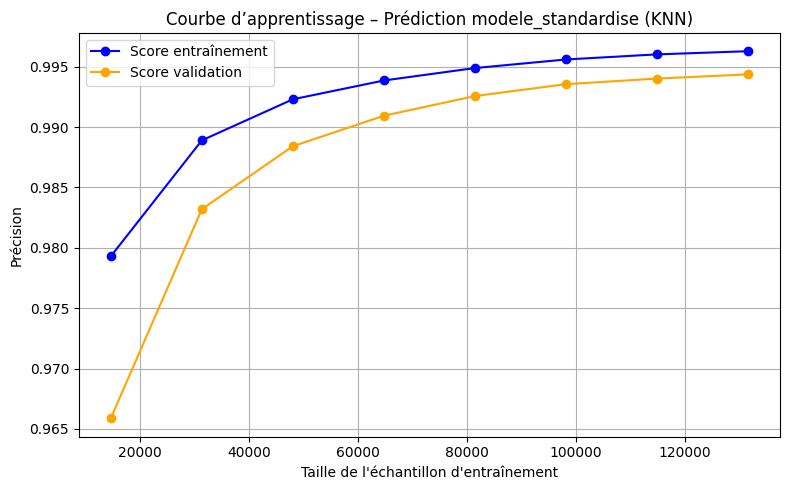

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.utils.multiclass import unique_labels

# --- 1. Colonnes utilisées ---
colonnes_features = [
    'x', 'y', 'altitude', 'hauteur', 'vitesse',
    'vitesse_calculee', 'delta_t', 'vz',
    'distance', 'temps_total', 'distance_totale',
    'longitude_depart'
]

# --- 2. Nettoyage de base ---
df_model = df_clean.dropna(subset=colonnes_features + ['modele_standardise'])

# --- 3. Features et cible ---
X = df_model[colonnes_features]
y = df_model['modele_standardise']

# --- 4. Encodage de la cible ---
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# --- 5. Échantillonnage avec nettoyage ---
df_sample = X.sample(frac=0.5, random_state=42)
X_small = df_sample.copy()
y_small = y.loc[X_small.index].copy()

# --- 6. Conversion forcée en numérique + nettoyage ---
X_small = X_small.apply(pd.to_numeric, errors='coerce')
mask_valid = X_small.replace([np.inf, -np.inf], np.nan).notnull().all(axis=1)
X_small = X_small[mask_valid]
y_small = y_small[mask_valid]

# --- 7. Filtrage des classes avec au moins 2 occurrences ---
counts = y_small.value_counts()
valid_classes = counts[counts >= 2].index
mask_valid_classes = y_small.isin(valid_classes)
X_small = X_small[mask_valid_classes]
y_small = y_small[mask_valid_classes]

# Ré-encodage des classes restantes
encoder_filtered = LabelEncoder()
y_small_encoded = encoder_filtered.fit_transform(y_small)

# --- 8. Split train/test ---
X_train, X_test, y_train, y_test = train_test_split(
    X_small, y_small_encoded, test_size=0.8, random_state=42, stratify=y_small_encoded
)

# --- 9. Modèle KNN ---
knn_model = KNeighborsClassifier(n_neighbors=5, weights='uniform', n_jobs=-1)
knn_model.fit(X_train, y_train)

# --- 10. Prédictions et rapport ---
y_pred = knn_model.predict(X_test)
present_labels = unique_labels(y_test, y_pred)

print(classification_report(
    y_test,
    y_pred,
    labels=present_labels,
    target_names=encoder_filtered.inverse_transform(present_labels),
    zero_division=0
))

# --- 11. Courbe d'apprentissage ---
train_sizes, train_scores, val_scores = learning_curve(
    knn_model,
    X_small,
    y_small_encoded,
    cv=3,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 0.9, 8),
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, 'o-', label='Score entraînement', color='blue')
plt.plot(train_sizes, val_mean, 'o-', label='Score validation', color='orange')
plt.title('Courbe d’apprentissage – Prédiction modele_standardise (KNN)')
plt.xlabel("Taille de l'échantillon d'entraînement")
plt.ylabel("Précision")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


                             precision    recall  f1-score   support

                     Air 2S       1.00      1.00      1.00      1538
                      Air 3       0.99      0.98      0.99      1452
                     Air 3S       1.00      1.00      1.00       831
                      Avata       1.00      0.98      0.99       686
                  Inspire 3       1.00      1.00      1.00     15322
            Matrice 300 RTK       1.00      1.00      1.00      2240
                Matrice 30T       1.00      1.00      1.00      2227
            Matrice 350 RTK       1.00      0.98      0.99       131
                 Matrice 4E       1.00      1.00      1.00      1814
                 Matrice 4T       0.99      0.96      0.98       110
                    Mavic 2       1.00      1.00      1.00       244
Mavic 2 Enterprise Advanced       1.00      0.95      0.97        20
    Mavic 2 Enterprise Dual       1.00      1.00      1.00      8618
               Mavic 2 Zoom      

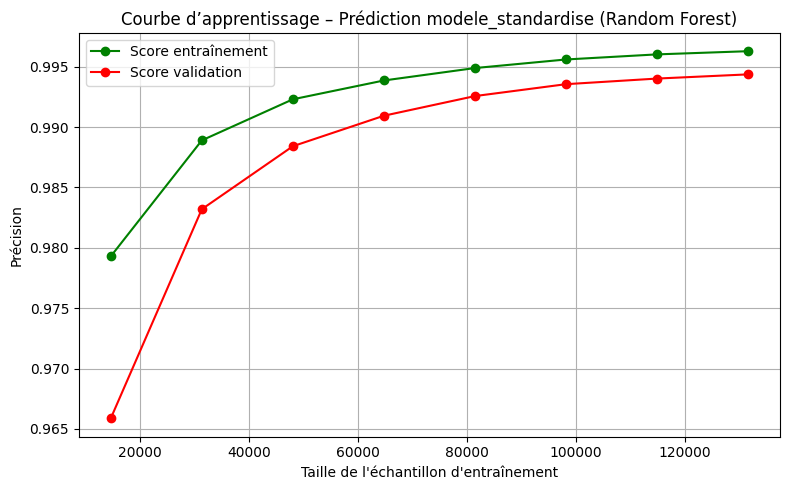

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# --- 1. Colonnes utilisées ---
colonnes_features = [
    'x', 'y', 'altitude', 'hauteur', 'vitesse',
    'vitesse_calculee', 'delta_t', 'vz',
    'distance', 'temps_total', 'distance_totale',
    'longitude_depart'
]

# --- 2. Nettoyage de base ---
df_model = df_clean.dropna(subset=colonnes_features + ['modele_standardise'])

# --- 3. Features et cible ---
X = df_model[colonnes_features]
y = df_model['modele_standardise']

# --- 4. Encodage de la cible ---
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# --- 5. Échantillonnage avec nettoyage ---
df_sample = X.sample(frac=0.5, random_state=42)
X_small = df_sample.copy()
y_small = y.loc[X_small.index].copy()

# --- 6. Conversion forcée en numérique + nettoyage ---
X_small = X_small.apply(pd.to_numeric, errors='coerce')
mask_valid = X_small.replace([np.inf, -np.inf], np.nan).notnull().all(axis=1)
X_small = X_small[mask_valid]
y_small = y_small[mask_valid]

# --- 7. Filtrage des classes avec au moins 2 occurrences ---
counts = y_small.value_counts()
valid_classes = counts[counts >= 2].index
mask_valid_classes = y_small.isin(valid_classes)
X_small = X_small[mask_valid_classes]
y_small = y_small[mask_valid_classes]

# Ré-encodage des classes restantes
encoder_filtered = LabelEncoder()
y_small_encoded = encoder_filtered.fit_transform(y_small)

# --- 8. Split train/test ---
X_train, X_test, y_train, y_test = train_test_split(
    X_small, y_small_encoded, test_size=0.8, random_state=42, stratify=y_small_encoded
)

# --- 9. Modèle Random Forest ---
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# --- 10. Prédictions et rapport ---
y_pred = rf_model.predict(X_test)

from sklearn.utils.multiclass import unique_labels
present_labels = unique_labels(y_test, y_pred)

print(classification_report(
    y_test,
    y_pred,
    labels=present_labels,
    target_names=encoder_filtered.inverse_transform(present_labels),
    zero_division=0
))


train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, 'o-', label='Score entraînement', color='green')
plt.plot(train_sizes, val_mean, 'o-', label='Score validation', color='red')
plt.title("Courbe d’apprentissage – Prédiction modele_standardise (Random Forest)")
plt.xlabel("Taille de l'échantillon d'entraînement")
plt.ylabel("Précision")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report
from sklearn.utils.multiclass import unique_labels

# --- 1. Colonnes utilisées ---
colonnes_features = [
    'x', 'y', 'altitude', 'hauteur', 'vitesse',
    'vitesse_calculee', 'delta_t', 'vz',
    'distance', 'temps_total', 'distance_totale',
    'longitude_depart'
]

# --- 2. Nettoyage de base ---
df_model = df_clean.dropna(subset=colonnes_features + ['modele_standardise'])

# --- 3. Features et cible ---
X = df_model[colonnes_features]
y = df_model['modele_standardise']

# --- 4. Encodage de la cible ---
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# --- 5. Échantillonnage avec nettoyage ---
df_sample = X.sample(frac=0.5, random_state=42)
X_small = df_sample.copy()
y_small = y.loc[X_small.index].copy()

# --- 6. Conversion forcée en numérique + nettoyage ---
X_small = X_small.apply(pd.to_numeric, errors='coerce')
mask_valid = X_small.replace([np.inf, -np.inf], np.nan).notnull().all(axis=1)
X_small = X_small[mask_valid]
y_small = y_small[mask_valid]

# --- 7. Filtrer les classes avec au moins 2 exemples ---
counts = y_small.value_counts()
classes_to_keep = counts[counts >= 2].index
mask_classes = y_small.isin(classes_to_keep)
X_small = X_small[mask_classes]
y_small = y_small[mask_classes]

# --- 8. Standardisation (obligatoire pour SVM) ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_small)

# --- 9. Ré-encodage après nettoyage et filtrage ---
y_small_encoded = encoder.transform(y_small)

# --- 10. Split train/test avec stratification ---
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_small_encoded, test_size=0.8, random_state=42, stratify=y_small_encoded
)

# --- 11. Modèle SVM ---
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale')  # ou 'linear' / 'poly'
svm_model.fit(X_train, y_train)

# --- 12. Prédictions ---
y_pred = svm_model.predict(X_test)

present_labels = unique_labels(y_test, y_pred)

# Utiliser encoder.inverse_transform pour récupérer les noms originaux de ces classes
target_names = encoder.inverse_transform(present_labels)

print(classification_report(
    y_test,
    y_pred,
    labels=present_labels,
    target_names=target_names,
    zero_division=0
))


                             precision    recall  f1-score   support

                     Air 2S       0.94      0.98      0.96      1538
                      Air 3       0.86      0.79      0.82      1452
                     Air 3S       0.83      0.86      0.84       831
                      Avata       0.82      0.13      0.22       686
                  Inspire 3       0.75      0.44      0.55     15322
            Matrice 300 RTK       0.93      0.13      0.22      2240
                Matrice 30T       0.90      0.92      0.91      2227
            Matrice 350 RTK       0.92      0.66      0.77       131
                 Matrice 4E       0.84      0.07      0.13      1814
                 Matrice 4T       1.00      0.04      0.07       110
                    Mavic 2       0.00      0.00      0.00       244
Mavic 2 Enterprise Advanced       1.00      0.95      0.97        20
    Mavic 2 Enterprise Dual       0.87      0.92      0.89      8618
               Mavic 2 Zoom      

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.utils.multiclass import unique_labels

# --- 1. Colonnes utilisées ---
colonnes_features = [
    'x', 'y', 'altitude', 'hauteur', 'vitesse',
    'vitesse_calculee', 'delta_t', 'vz',
    'distance', 'temps_total', 'distance_totale',
    'longitude_depart'
]

# --- 2. Nettoyage de base ---
df_model = df_clean.dropna(subset=colonnes_features + ['modele_standardise'])

# --- 3. Features et cible ---
X = df_model[colonnes_features]
y = df_model['modele_standardise']

# --- 4. Encodage de la cible ---
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# --- 5. Échantillonnage avec nettoyage ---
df_sample = X.sample(frac=0.5, random_state=42)
X_small = df_sample.copy()
y_small = y.loc[X_small.index].copy()

# --- 6. Conversion forcée en numérique + nettoyage ---
X_small = X_small.apply(pd.to_numeric, errors='coerce')
mask_valid = X_small.replace([np.inf, -np.inf], np.nan).notnull().all(axis=1)
X_small = X_small[mask_valid]
y_small = y_small[mask_valid]

# --- 7. Filtrage des classes avec au moins 2 occurrences ---
counts = y_small.value_counts()
valid_classes = counts[counts >= 2].index
mask_valid_classes = y_small.isin(valid_classes)
X_small = X_small[mask_valid_classes]
y_small = y_small[mask_valid_classes]

# Ré-encodage des classes restantes
encoder_filtered = LabelEncoder()
y_small_encoded = encoder_filtered.fit_transform(y_small)

# --- 8. Split train/test ---
X_train, X_test, y_train, y_test = train_test_split(
    X_small, y_small_encoded, test_size=0.8, random_state=42, stratify=y_small_encoded
)

# --- 9. Modèle CatBoost ---
catboost_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    loss_function='MultiClass',
    verbose=0,
    random_state=42
)
catboost_model.fit(X_train, y_train)

# --- 10. Prédictions et rapport ---
y_pred = catboost_model.predict(X_test).flatten()

present_labels = unique_labels(y_test, y_pred)

print(classification_report(
    y_test,
    y_pred,
    labels=present_labels,
    target_names=encoder_filtered.inverse_transform(present_labels),
    zero_division=0
))


                             precision    recall  f1-score   support

                     Air 2S       1.00      1.00      1.00      1538
                      Air 3       0.98      0.97      0.97      1452
                     Air 3S       0.98      0.99      0.99       831
                      Avata       1.00      0.97      0.98       686
                  Inspire 3       0.99      0.99      0.99     15322
            Matrice 300 RTK       1.00      1.00      1.00      2240
                Matrice 30T       0.99      1.00      0.99      2227
            Matrice 350 RTK       0.92      0.85      0.88       131
                 Matrice 4E       1.00      1.00      1.00      1814
                 Matrice 4T       0.95      0.88      0.92       110
                    Mavic 2       0.99      0.95      0.97       244
Mavic 2 Enterprise Advanced       0.94      0.80      0.86        20
    Mavic 2 Enterprise Dual       1.00      1.00      1.00      8618
               Mavic 2 Zoom      

In [59]:
import joblib
import os


# --- 7. Sauvegarde des modèles ---
print("\nSauvegarde des modèles...")

os.makedirs('models', exist_ok=True)

joblib.dump(knn_model, 'models/knn_model.pkl')
joblib.dump(rf_model, 'models/rf_model.pkl')
joblib.dump(catboost_model, 'models/catboost_model.pkl')
joblib.dump(svm_model, 'models/svm_model.pkl')
joblib.dump(encoder_filtered, 'models/label_encoder.pkl')


print("Tous les modèles ont été sauvegardés dans le dossier 'models/'")



Sauvegarde des modèles...
Tous les modèles ont été sauvegardés dans le dossier 'models/'


In [60]:

# --- Sauvegarde en CSV ---
df_model.to_csv('df_model_clean.csv', index=False)

In [61]:
# Vérification rapide
print(df_model.shape)

(475067, 22)


In [62]:
print("Classes entraînées :", encoder_filtered.classes_)
print("Classes chargées :", encoder.classes_)


Classes entraînées : ['Air 2S' 'Air 3' 'Air 3S' 'Avata' 'Inspire 3' 'Matrice 300 RTK'
 'Matrice 30T' 'Matrice 350 RTK' 'Matrice 4E' 'Matrice 4T' 'Mavic 2'
 'Mavic 2 Enterprise Advanced' 'Mavic 2 Enterprise Dual' 'Mavic 2 Zoom'
 'Mavic 3' 'Mavic 3 Classic' 'Mavic 3 Pro' 'Mavic 3E' 'Mavic 3M'
 'Mavic 3T' 'Mavic 4 Pro' 'Mavic Pro' 'Mini 2 SE' 'Mini 3 Pro' 'Mini 4K'
 'Mini SE' 'Phantom 4 Pro' 'Phantom 4 RTK']
Classes chargées : ['Air 2S' 'Air 3' 'Air 3S' 'Avata' 'Extra 330S' 'Inspire 3'
 'Matrice 300 RTK' 'Matrice 30T' 'Matrice 350 RTK' 'Matrice 4E'
 'Matrice 4T' 'Mavic 2' 'Mavic 2 Enterprise Advanced'
 'Mavic 2 Enterprise Dual' 'Mavic 2 Zoom' 'Mavic 3' 'Mavic 3 Classic'
 'Mavic 3 Pro' 'Mavic 3E' 'Mavic 3M' 'Mavic 3T' 'Mavic 4 Pro' 'Mavic Pro'
 'Mini 2 SE' 'Mini 3 Pro' 'Mini 4K' 'Mini SE' 'Phantom 4 Pro'
 'Phantom 4 RTK']
